In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n = 236
#novel number
t = 'Jungle_book'
#novel name
s = 1
#how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [7]:
df_novel.head()

,0
0,"Tiger!"""
1,Mowgli's Song The White Seal Lukanno...
2,"This is the hour of pride and power, T..."
3,"Oh, hear the call!--Good hunting all T..."
4,Night-Song in the Jungle It was seven o'clock...


Create the wrd_length and total_char columns.

In [8]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [9]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [10]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [11]:
df_novel.head()

,0,wrd_length,total_char
0,"Tiger!""",[5],5
1,Mowgli's Song The White Seal Lukanno...,"[6, 2, 4, 3, 5, 4, 8, 16, 6, 2, 5, 6, 2, 3, 9,...",267
2,"This is the hour of pride and power, T...","[4, 2, 3, 4, 2, 5, 3, 5, 5, 3, 4, 3, 4]",47
3,"Oh, hear the call!--Good hunting all T...","[2, 4, 3, 4, 4, 7, 3, 4, 4, 3, 6, 3]",47
4,Night-Song in the Jungle It was seven o'clock...,"[10, 2, 3, 6, 2, 3, 5, 7, 2, 1, 4, 4, 7, 2, 3,...",203


Create syllable count column

In [12]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [13]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [14]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [15]:
df_novel['syl_count'] = syl_count_arr

In [16]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,"Tiger!""",[5],5,[2]
1,Mowgli's Song The White Seal Lukanno...,"[6, 2, 4, 3, 5, 4, 8, 16, 6, 2, 5, 6, 2, 3, 9,...",267,"[2, 0, 1, 1, 1, 2, 3, 6, 2, 0, 1, 2, 1, 1, 3, ..."
2,"This is the hour of pride and power, T...","[4, 2, 3, 4, 2, 5, 3, 5, 5, 3, 4, 3, 4]",47,"[1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1]"
3,"Oh, hear the call!--Good hunting all T...","[2, 4, 3, 4, 4, 7, 3, 4, 4, 3, 6, 3]",47,"[1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]"
4,Night-Song in the Jungle It was seven o'clock...,"[10, 2, 3, 6, 2, 3, 5, 7, 2, 1, 4, 4, 7, 2, 3,...",203,"[2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 3, 1, 1, ..."


In [17]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [18]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [19]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [20]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [21]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [22]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [23]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [24]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,"Tiger!""",[5],5,[2],2,0.0000
1,Mowgli's Song The White Seal Lukanno...,"[6, 2, 4, 3, 5, 4, 8, 16, 6, 2, 5, 6, 2, 3, 9,...",267,[2 0 1 1 1 2 3 6 2 0 1 2 1 1 3 1 1 1 3 1 3 0 2...,79,0.0500
2,"This is the hour of pride and power, T...","[4, 2, 3, 4, 2, 5, 3, 5, 5, 3, 4, 3, 4]",47,[1 1 1 1 1 1 1 2 2 1 1 1 1],15,0.0000
3,"Oh, hear the call!--Good hunting all T...","[2, 4, 3, 4, 4, 7, 3, 4, 4, 3, 6, 3]",47,[1 2 1 1 1 2 1 1 1 1 1 1],14,0.0000
4,Night-Song in the Jungle It was seven o'clock...,"[10, 2, 3, 6, 2, 3, 5, 7, 2, 1, 4, 4, 7, 2, 3,...",203,[2 1 1 1 1 1 2 2 1 1 2 1 3 1 1 2 1 1 2 1 1 1 1...,63,0.3275


Create cluster dataframe - remove columns that can't be used

In [25]:
df_cluster = df_novel.drop('wrd_length', 1)

In [26]:
df_cluster = df_cluster.drop('syl_count', 1)

In [27]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,"Tiger!""",5,2,0.0000
1,Mowgli's Song The White Seal Lukanno...,267,79,0.0500
2,"This is the hour of pride and power, T...",47,15,0.0000
3,"Oh, hear the call!--Good hunting all T...",47,14,0.0000
4,Night-Song in the Jungle It was seven o'clock...,203,63,0.3275


Create 20 clusters on scaled data

In [28]:
X = df_cluster.drop(0, axis=1)

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [31]:
df_cluster['cluster'] = km.labels_

In [32]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,52.615578,16.326633,-0.000918
1,104.347826,32.434783,0.328524
2,125.360825,38.804124,0.018684
3,315.931034,98.206897,0.086535
4,42.515464,13.329897,0.492003
5,40.565789,12.947368,-0.520951
6,181.946667,56.200000,0.207060
7,226.272727,70.272727,-0.009492
8,36.028902,11.179191,-0.201615


In [33]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [34]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

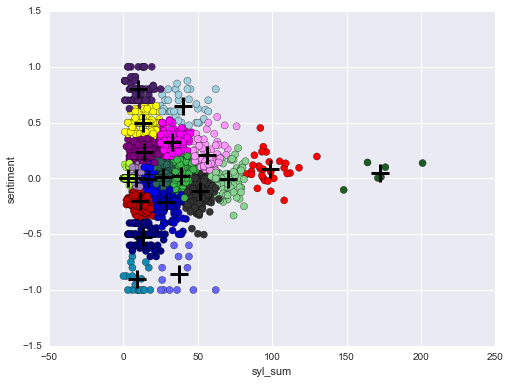

In [35]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [36]:
df_cluster_3 = df_cluster

In [37]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,"Tiger!""",5,2,0.0000,9
1,Mowgli's Song The White Seal Lukanno...,267,79,0.0500,7
2,"This is the hour of pride and power, T...",47,15,0.0000,0
3,"Oh, hear the call!--Good hunting all T...",47,14,0.0000,0
4,Night-Song in the Jungle It was seven o'clock...,203,63,0.3275,6


In [38]:
X = df_cluster_3.drop(0, axis=1)

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [41]:
df_cluster_3['cluster'] = km.labels_

In [42]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,200.169972,61.847025,0.020598
1,38.446325,11.966151,-0.007610
2,75.602302,23.464194,0.104134


Create 3 Clusters with no syl_sum

In [43]:
df_cluster_no_syl = df_cluster

In [44]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [45]:
X = df_cluster_no_syl.drop(0, axis=1)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [48]:
df_cluster_no_syl['cluster'] = km.labels_

In [49]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,72.104119,0.174653
1,38.263664,-0.044004
2,200.169972,0.020598


Create 5 Clusters

In [50]:
df_cluster_5 = df_cluster

In [51]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,"Tiger!""",5,2,0.0000,1
1,Mowgli's Song The White Seal Lukanno...,267,79,0.0500,0
2,"This is the hour of pride and power, T...",47,15,0.0000,2
3,"Oh, hear the call!--Good hunting all T...",47,14,0.0000,2
4,Night-Song in the Jungle It was seven o'clock...,203,63,0.3275,0


In [52]:
X = df_cluster_5.drop(0, axis=1)

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [55]:
df_cluster_5['cluster'] = km.labels_

In [56]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,21.798363,6.778274,0.015358
1,202.837758,62.684366,0.024706
2,80.029940,24.806886,0.038812
3,74.771337,23.270531,-0.192121
4,49.073593,15.346320,0.594504


Find ideal amount of clusters for novel

In [ ]:
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

In [ ]:
k_range = range(2,150)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

In [ ]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silihouette Coefficient')
plt.grid(True)

Find Sentiment Pattern - need to work on this code to make it more universal.

20 pieces

In [57]:
df_novel['total_char'].sum()

209288

In [58]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [59]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [61]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:173]
df_novel['total_char'][173:335]
df_novel['total_char'][335:541]
df_novel['total_char'][541:685]
df_novel['total_char'][685:875]
df_novel['total_char'][875:1008]
df_novel['total_char'][1008:1191]
df_novel['total_char'][1191:1337]
df_novel['total_char'][1337:1519]
df_novel['total_char'][1519:1680]
df_novel['total_char'][1680:1835]
df_novel['total_char'][1835:1947]
df_novel['total_char'][1947:2088]
df_novel['total_char'][2088:2252]
df_novel['total_char'][2252:2390]
df_novel['total_char'][2390:2547]
df_novel['total_char'][2547:2634]
df_novel['total_char'][2634:2767]
df_novel['total_char'][2767:2983]
df_novel['total_char'][2983:3185]


In [62]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
173
0.0230910032753
173
335
0.061023633431
335
541
0.0245979677685
541
685
0.0469018385921
685
875
0.0320838373893
875
1008
0.0498135693671
1008
1191
0.0341589152979
1191
1337
0.0265877422299
1337
1519
0.0111247746962
1519
1680
0.000764933981937
1680
1835
-0.00255220212882
1835
1947
0.0733902561972
1947
2088
-0.0100295509258
2088
2252
0.0259454002129
2252
2390
0.00729006747077
2390
2547
0.0250559207247
2547
2634
0.00018270059321
2634
2767
-0.00661707210744
2767
2983
-0.00242511753507
2983
3185
0.0379498546237


In [63]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.023091    0.06102363  0.02459797  0.04690184  0.03208384  0.04981357
  0.03415892  0.02658774  0.01112477  0.00076493 -0.0025522   0.07339026
 -0.01002955  0.0259454   0.00729007  0.02505592  0.0001827  -0.00661707
 -0.00242512  0.03794985]


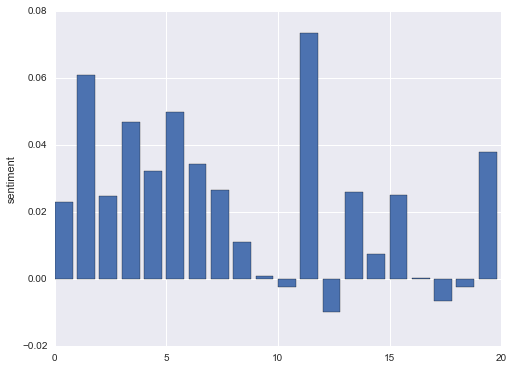

In [64]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern

In [67]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
3198,Somebody's catching it now!,"[8, 2, 8, 2, 3]",23,"[4, 0, 2, 1, 1]",8,0.750000
3199,ALL THE BEASTS TOGETHER Children of the ...,"[3, 3, 6, 8, 8, 2, 3, 4, 3, 2, 7, 4, 2, 3, 6, ...",112,"[1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, ...",36,0.000000
3200,"See our line across the plain, Like a hee...","[3, 3, 4, 6, 3, 5, 4, 1, 9, 4, 5, 8, 8, 7, 3, ...",93,"[1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 3, 2, 2, 1, ...",29,-0.044643
3201,"While the men that walk beside, Dusty, si...","[5, 3, 3, 4, 4, 6, 5, 6, 10, 3, 3, 4, 3, 2, 2,...",89,"[1, 1, 1, 1, 1, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, ...",28,-0.200000
3202,"Children of the Camp are we, Serving e...","[8, 2, 3, 4, 3, 2, 7, 4, 2, 3, 6, 8, 2, 3, 4, ...",92,"[2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, ...",29,0.000000


In [68]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -200
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [69]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:1139]
df_novel['total_char'][1139:2141]
df_novel['total_char'][2141:3193]


KeyboardInterrupt: 

In [70]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
1139
0.0395771577624
1139
2141
0.0132952269625
2141
3193
0.0141977015627


In [71]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.03957716  0.01329523  0.0141977 ]


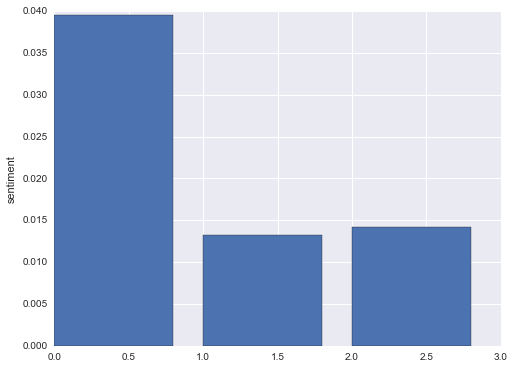

In [72]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers